In [1]:
# Notebook for Testing
# https://signal.vercel.app/edit
# https://github.com/lolzone13/Markov-Music.git
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
!unzip custom.zip

Archive:  custom.zip
replace custom/albeniz/alb_esp1.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import mido
from music21 import converter, instrument, note, chord, stream
from mido import MidiFile
import numpy
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import string
import re

In [ ]:
!unzip custom.zip

Archive:  custom.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of custom.zip or
        custom.zip.zip, and cannot find custom.zip.ZIP, period.


In [ ]:
# https://github.com/Djadih/DataScience_Project


In [3]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [4]:
def plot_notes_distri(midi_arr, normalized = True):
  size, num_notes = midi_arr.shape
  notes_freq = np.zeros(num_notes)
  for i in range(size):
    for j in range(num_notes):
      if midi_arr[i, j] > 0:
        notes_freq[j] += 1
  if normalized:
    notes_freq /= np.sum(notes_freq)
  notes = []
  for f in notes_freq:
    notes += [f]*100
  plt.plot(np.linspace(0,num_notes, num_notes*100), notes, color='red')
  plt.xlabel('notes #')
  plt.ylabel('distribution')
  plt.title('Distribution of notes')
  plt.show()


In [ ]:

mid = mido.MidiFile('/content/custom/debussy/debussy_cc_2.mid', clip=True)
# mid.tracks[0]
midi_array = mid2arry(mid)


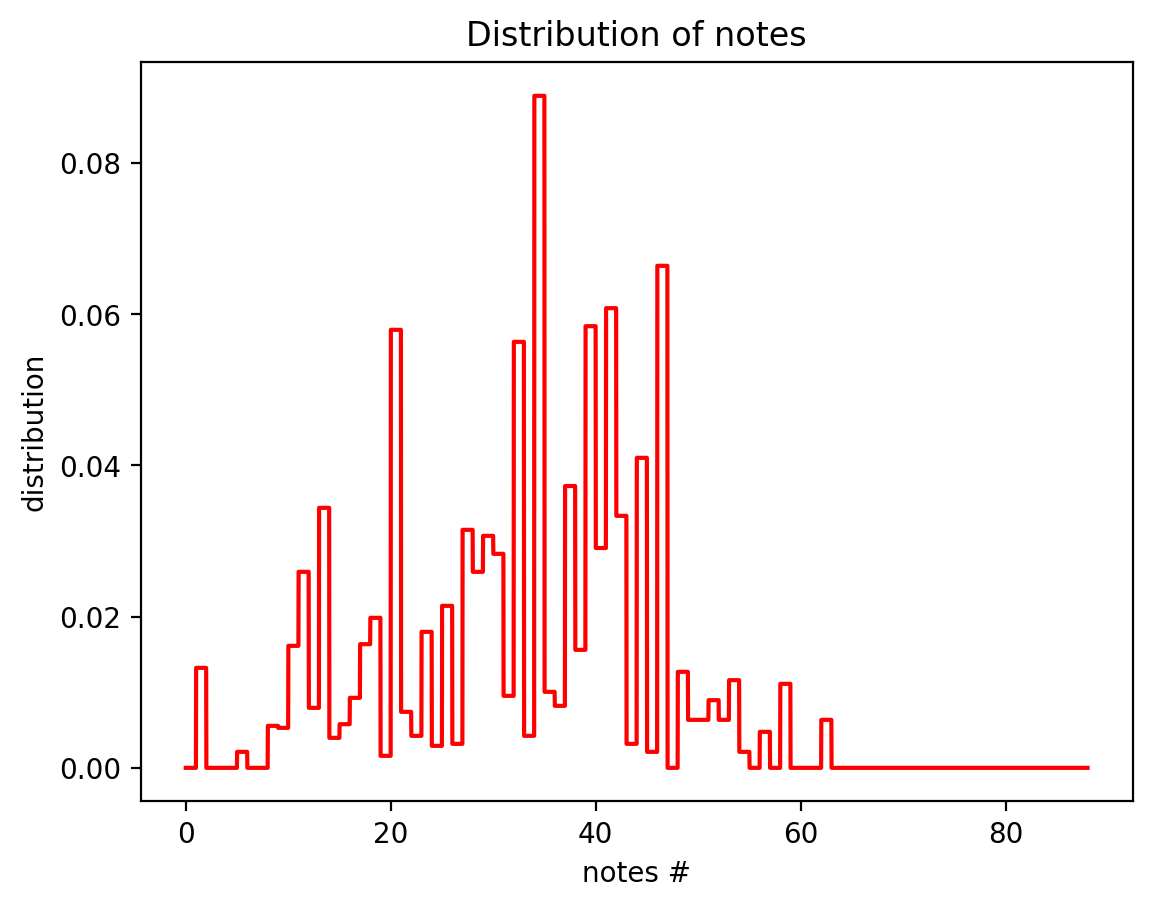

In [ ]:
plot_notes_distri(midi_array)

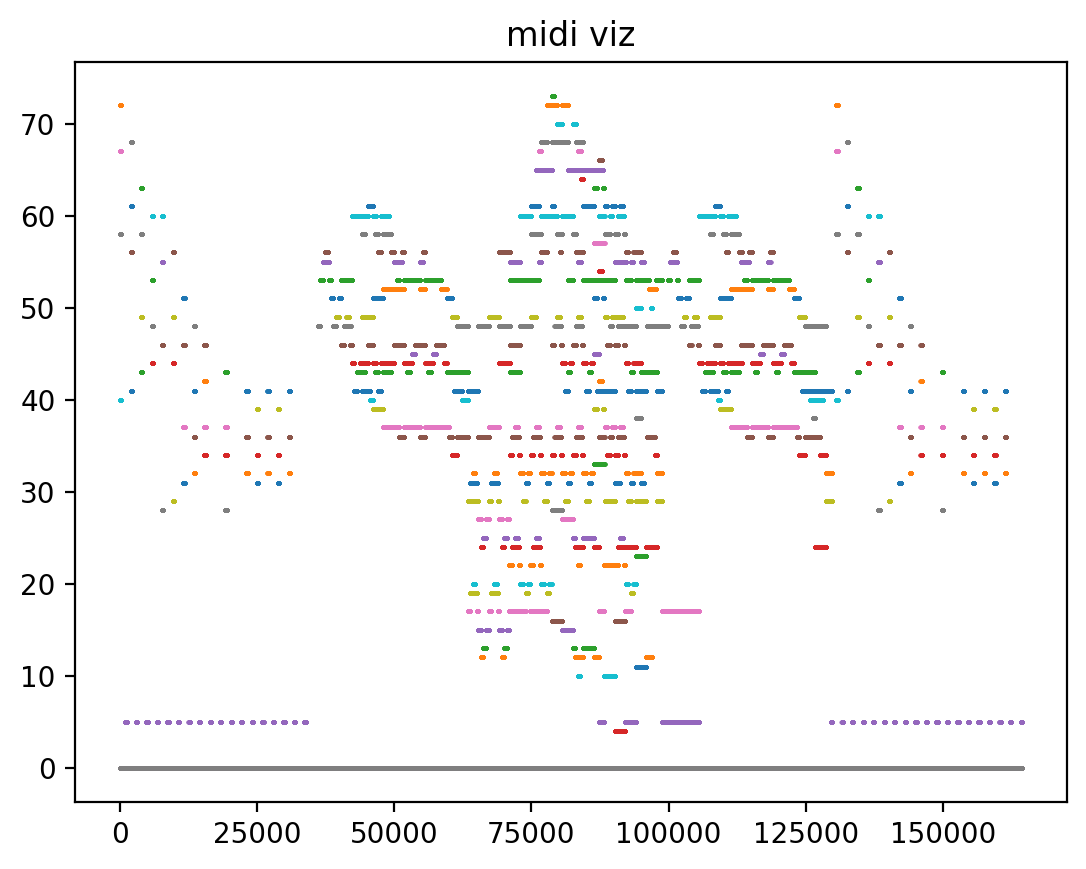

In [ ]:
plt.plot(range(midi_array.shape[0]), np.multiply(np.where(midi_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("midi viz")
plt.show()

In [ ]:
midi_array.shape

(164398, 88)

In [5]:
def get_midi_array(folder_path):
  %cd $folder_path
  midi_files = glob.glob('*.mid')

  midi_array = np.empty((0,88))
  for mi in midi_files:
    mid = mido.MidiFile(folder_path + '/' + mi, clip=True)
    midi_arr = np.array( mid2arry(mid))
    midi_array = np.concatenate((midi_array, midi_arr), axis=0)

  return midi_array

# midi_array = get_midi_array('/content/debussy')
# print(midi_array.shape)

In [43]:
def encode_vector_to_state(v):
  state = ""
  cnt = 1
  n = v.size
  for i in range(1,n):
    if v[i] == v[i-1]:
      cnt +=1
    else:
      state += str(v[i-1]) + 'x' + str(cnt) + '-'
      cnt = 1
  
  state += str(v[-1]) + 'x' + str(cnt)
  return state
  
# print(encode_vector(np.array([0,0,1,1,1,1,4,5,0,0,0,0,0,45,0,0,0,0])))

def decode_state_to_vector(state):
  v = []
  uniq = state.split('-')
  for el in uniq:
    num, cnt = el.split('x')
    v += [int(float(num))]*int(float(cnt))
  return np.array(v)

# print(decode_state_to_vector('0x2-1x4-4x1-5x1-0x5-45x1-0x4'))

In [ ]:
uniq_midi_rows = np.unique(midi_array, axis=0)

In [ ]:
print(uniq_midi_rows.shape)
print("uniq/total % = ", 100*uniq_midi_rows.shape[0]/midi_array.shape[0])
num_states = uniq_midi_rows.shape[0]

(350, 88)
uniq/total % =  0.22751057924193474


In [ ]:
states = [encode_vector_to_state(uniq_midi_rows[i]) for i in range(num_states)]
print(states[0:10])

['0x88', '0x50-31x1-0x7-35x1-0x3-37x1-0x25', '0x40-31x1-0x7-31x1-0x3-31x1-0x35', '0x40-39x1-0x47', '0x40-41x1-0x47', '0x38-42x1-0x49', '0x38-44x1-0x7-52x1-0x41', '0x38-44x1-0x1-35x1-0x5-52x1-0x41', '0x37-38x1-0x2-38x1-0x47', '0x36-38x1-0x6-45x1-0x44']


In [ ]:
# def state_to_idx(state, states):
#   return states.index(state)

In [30]:
# transition matrix
def get_transition_prob(midi_array, num_states, states, epsilon = 1e-12):
  transition_prob = np.zeros((num_states, num_states))
  # now fill it
  for i in range(midi_array.shape[0]-1):
    curr_st = encode_vector_to_state(midi_array[i])
    next_st = encode_vector_to_state(midi_array[i+1])
    transition_prob[states.index(curr_st), states.index(next_st)] += 1

  # now normalize to make it prob distri
  for i in range(num_states):
    sum = np.sum(transition_prob[i])
    transition_prob[i] = transition_prob[i]/(sum + epsilon)
    err = 1 - np.sum(transition_prob[i])
    transition_prob[i,0] += err

  return transition_prob

# transition_prob = get_transition_prob(midi_array, num_states, states)

In [ ]:
transition_prob[:5, :5]

array([[9.98793838e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.22044605e-15, 9.97826087e-01, 0.00000000e+00, 0.00000000e+00,
        2.17391304e-03],
       [2.22044605e-15, 0.00000000e+00, 9.97826087e-01, 2.17391304e-03,
        0.00000000e+00],
       [4.99600361e-14, 5.00000000e-02, 0.00000000e+00, 9.50000000e-01,
        0.00000000e+00],
       [4.10782519e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.95833333e-01]])

In [ ]:
print(np.sum(transition_prob[0]))
print(transition_prob[0])

In [33]:
def random_walk(transition_prob, init_state = 0, WALK_LENGTH = 100000):
  '''
  returns seq. of index of states
  '''
  num_states = transition_prob.shape[0]
  walk = []
  curr_st = init_state
  for i in range(WALK_LENGTH):
    walk.append(curr_st)
    next_st = np.random.choice(np.arange(num_states), p=transition_prob[curr_st])
    curr_st = next_st
  
  return np.array(walk) 


In [ ]:
generated_midi_seq_idx = random_walk(transition_prob, 0)
print(generated_midi_seq_idx[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


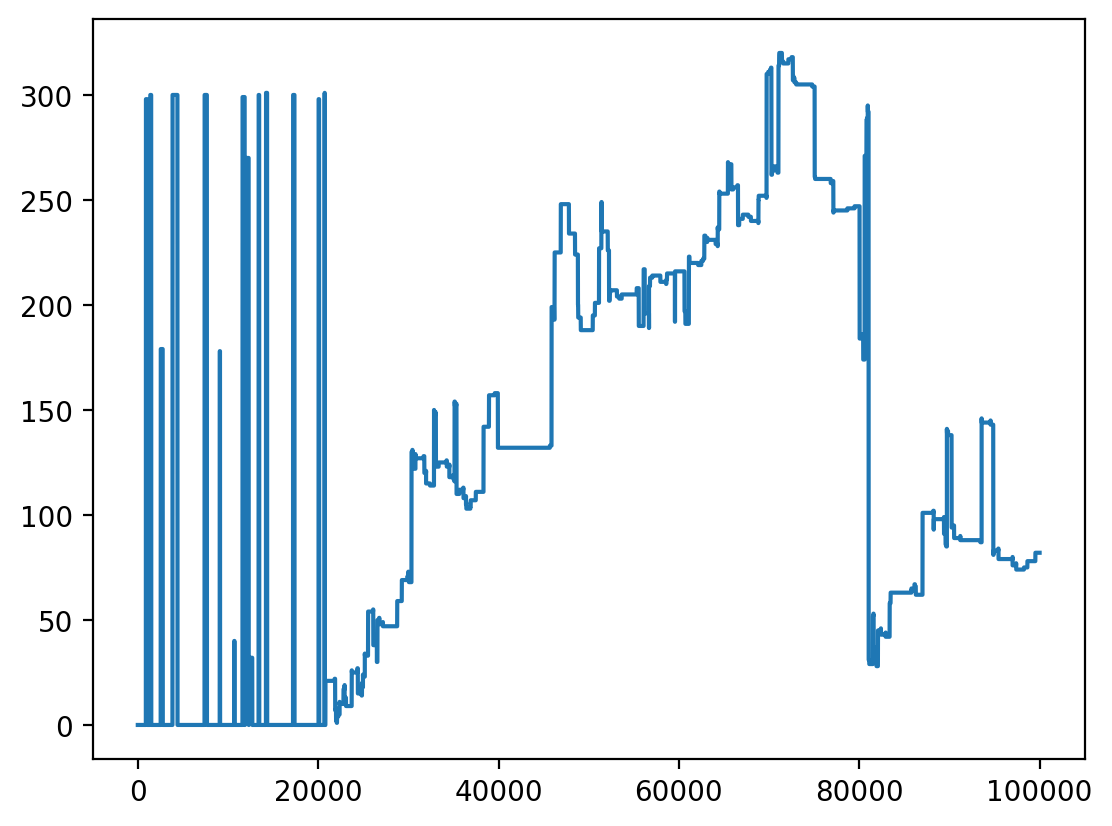

In [ ]:
plt.plot(generated_midi_seq_idx)

In [ ]:
generated_midi_array = np.zeros((generated_midi_seq_idx.size, 88))
i = 0
for idx in generated_midi_seq_idx:
  state = states[idx]
  vector = decode_state_to_vector(state).reshape(1,-1)
  generated_midi_array[i] = vector
  i += 1

generated_midi_array = generated_midi_array.astype('int')

In [ ]:
# print(generated_midi_array.shape)
generated_midi_array[:4, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [16]:
# mid.tracks[0][5]
def get_tempo(mid):
  track_info = ''
  for m in mid.tracks[0]:
    track_info += str(m)
  # print(track_info)

  tempos_str = re.findall(r'tempo=(.*?),',track_info)
  tempos = np.array([int(t) for t in tempos_str])
  # print('tempo mean:', int(np.mean(tempos)),'max:', np.max(tempos),'min:',np.min(tempos))
  return int(np.mean(tempos))

In [ ]:
# A tempo marking of 60 BPM equals one beat per second

mid_new = arry2mid(generated_midi_array, 800000)
mid_new.save('midi_gen3.mid')

In [ ]:
'''
TODO:
visualize sound
train and test to get samples
implement max and min count of notes
try softmax distri
format code + comments
'''

'\nTODO:\nwrite functions\ntry increase order\ntry softmax distri\nplay midi in colab\nbatch train \nHMM ?\n'

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi
import pretty_midi
from IPython import display


In [ ]:
_SAMPLING_RATE = 44000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  # return waveform_short
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)


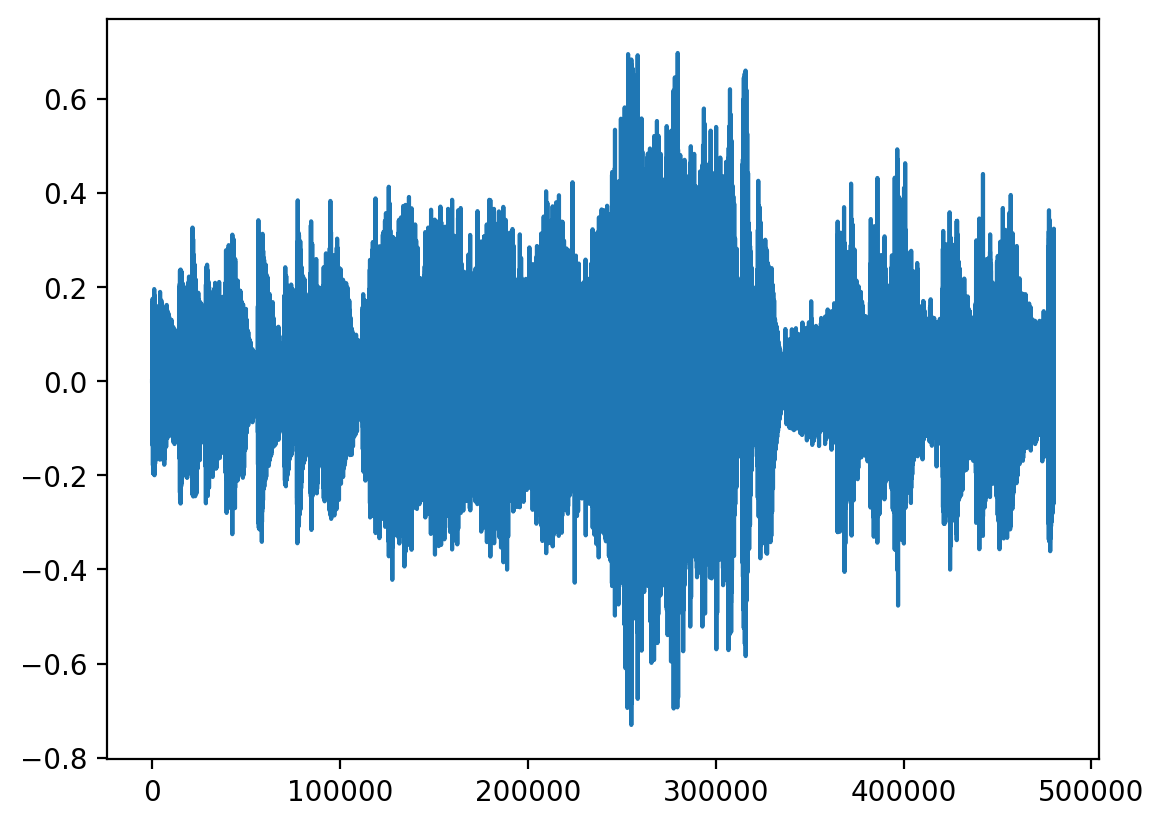

In [ ]:
# w = display_audio(pm)
# print(w.shape)
plt.plot(w)

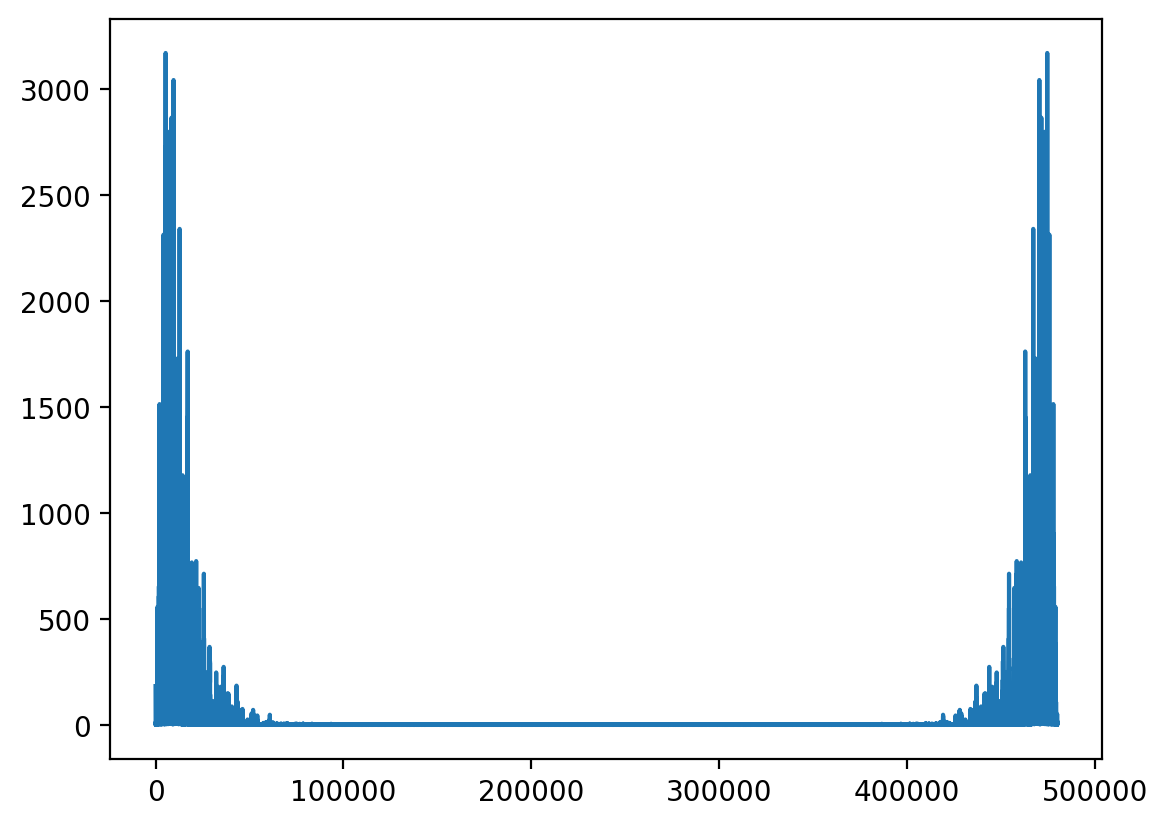

In [ ]:
plt.plot(np.abs(np.fft.fft(w)))

In [ ]:
np.abs(np.fft.fft(w))[:100]

array([1.83356412e+02, 4.27549601e+01, 2.30507388e+01, 4.19691052e+01,
       3.35500631e+01, 1.96495360e+01, 8.02632911e+00, 2.07923891e+01,
       2.52251907e+01, 7.30687189e+00, 1.25841466e+01, 2.43288571e+01,
       1.24672000e+01, 4.28825812e+00, 1.28053131e+01, 2.14851032e+01,
       3.10969122e+01, 9.75773229e+00, 3.05523989e+01, 3.38033934e+00,
       8.48530249e+00, 1.48076907e+01, 1.75825943e+01, 5.98026750e+00,
       1.54205525e+01, 1.75400874e+01, 1.37337435e+01, 6.02372564e+00,
       8.81954016e+00, 5.14766080e+00, 1.08579363e+01, 8.18474250e+00,
       5.42258701e+00, 1.30328492e+01, 1.89901775e+01, 1.70680778e+01,
       1.27096905e+01, 1.13704639e+01, 3.27747763e+00, 7.45305014e+00,
       1.18389834e+00, 1.76219022e+01, 1.15956409e+01, 2.33598596e+00,
       4.26350528e+00, 4.76164834e+00, 4.34677792e+00, 4.00454332e+00,
       9.85839844e+00, 1.27810898e+01, 1.34219617e+01, 5.53595559e+00,
       1.59312033e+00, 1.41361706e+01, 8.44346860e+00, 2.99174853e+00,
      

In [ ]:
sample_file = '/content/custom/mozart/mz_545_1.mid'
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
In midi files, each Note has a distinct midi number ranging from 21 to 108
Dimension = n rows * 88 columns, each row contains the state of 88 notes at a particular time step. The notes out of piano keyboard range will be ignored.
The values in the array represent velocity (0 means note off, while (0:127] means note on).
'''

In [ ]:
!unzip custom.zip

In [12]:
%cd /content/custom

/content/custom


In [ ]:
folder_path = '/content/custom'
for f_path in glob.glob(folder_path + '/*/'):
    # get tempo
    print(f_path)
  

In [44]:
def train_and_generate(folder_path):
  i = 0
  for f_path in sorted(glob.glob(folder_path + '/*/')):
    if i > 1:
      break
    i += 1
    # get tempo
    print(f_path)
    midi_files = glob.glob(f_path + '/*.mid')
    mid = mido.MidiFile(midi_files[0], clip=True)
    tempo = get_tempo(mid)
    print(f'tempo = {tempo}')
    # get midi_array
    midi_array = get_midi_array(f_path)
    uniq_midi_rows = np.unique(midi_array, axis=0)
    num_states = uniq_midi_rows.shape[0]
    states = [encode_vector_to_state(uniq_midi_rows[i]) for i in range(num_states)]
    print(states)
    transition_prob = get_transition_prob(midi_array, num_states, states)
    print(f'transition matrix generated!')
    # generate
    generated_midi_seq_idx = random_walk(transition_prob, 0)
    generated_midi_array = np.zeros((generated_midi_seq_idx.size, 88))
    generated_midi_array = generated_midi_array.astype('int')
    for idx in generated_midi_seq_idx:
      state = states[idx]
      vector = decode_state_to_vector(state).reshape(1,-1)
      generated_midi_array[i] = vector

    generated_midi_array = generated_midi_array.astype('int')
    print('saving midi file')
    mid_new = arry2mid(generated_midi_array, tempo)
    %cd $f_path
    mid_new.save('midi_gen55555.mid')
    print('done')


In [45]:
train_and_generate('/content/custom')

/content/custom/albeniz/
tempo = 1000560
/content/custom/albeniz
['0.0x88', '0.0x70-27.0x1-0.0x6-39.0x1-0.0x10', '0.0x67-32.0x1-0.0x8-38.0x1-0.0x11', '0.0x67-50.0x1-0.0x20', '0.0x65-27.0x1-0.0x8-39.0x1-0.0x13', '0.0x64-32.0x1-0.0x7-40.0x1-0.0x15', '0.0x63-27.0x1-0.0x15-39.0x1-0.0x8', '0.0x63-27.0x1-0.0x5-39.0x1-0.0x18', '0.0x63-42.0x1-0.0x24', '0.0x63-54.0x1-0.0x24', '0.0x62-27.0x1-0.0x7-39.0x1-0.0x17', '0.0x62-59.0x1-0.0x25', '0.0x61-54.0x1-0.0x26', '0.0x60-27.0x1-0.0x4-39.0x1-0.0x22', '0.0x60-33.0x1-0.0x6-42.0x1-0.0x20', '0.0x60-39.0x1-0.0x6-49.0x1-0.0x20', '0.0x60-39.0x1-0.0x6-51.0x1-0.0x20', '0.0x60-42.0x1-0.0x27', '0.0x60-49.0x1-0.0x6-64.0x1-0.0x20', '0.0x60-54.0x1-0.0x27', '0.0x60-55.0x1-0.0x27', '0.0x59-57.0x1-0.0x28', '0.0x59-59.0x1-0.0x28', '0.0x58-27.0x1-0.0x8-39.0x1-0.0x20', '0.0x58-30.0x1-0.0x6-41.0x1-0.0x22', '0.0x58-35.0x1-0.0x29', '0.0x58-49.0x1-0.0x29', '0.0x58-54.0x1-0.0x29', '0.0x58-60.0x1-0.0x29', '0.0x58-62.0x1-0.0x29', '0.0x57-27.0x1-0.0x5-39.0x1-0.0x24', '0.0x57-3

KeyboardInterrupt: ignored

In [ ]:
sorted(glob.glob('/content/custom/*/'))

In [ ]:
train_and_generate('/content/custom')